## 1. Import Library
___

In [1]:
import os
import random
import numpy as np 
import pandas as pd
import gc

from glob import glob
from tqdm import tqdm
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

from PIL import Image
import cv2

import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

#### Configuration

In [2]:
class CFG:
    debug = False
    output_dir = 'runs/predict'

    seed = 42
    img_size = [256,256]
    input_format = 'RGB'
    imgdir = '/kaggle/input/colonoscopy-256x256-resized-png'

    ims_per_batch = 8
    num_workers = 4

    model_name = 'MViTv2_T' ## Tiny Version

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(CFG.output_dir, exist_ok=True)

#### Install Detectron2 Library

In [3]:
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.0 MB/s eta 0:00:00


## 2. Utils
___

In [4]:
def format_pred(labels, boxes, scores):
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.float32)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)

In [5]:
def string_decoder(predict_string):
    s = predict_string.split(' ')
    class_id = [x for x in (s[0::6])]
    score = [x for x in (s[1::6])]
    x_min = [x for x in (s[2::6])]
    y_min = [x for x in (s[3::6])]
    x_max = [x for x in (s[4::6])]
    y_max = [x for x in (s[5::6])]

    return class_id, score, x_min, y_min, x_max, y_max

In [6]:
!pip install -q map-boxes
from map_boxes import mean_average_precision_for_boxes

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


## 3. Build Dataset_dicts
___

- **궤양**: `ulcer(label: 0)`

- **용종**: `polyp(label: 1)`

- **암**: `cancer(label: 2)`

In [7]:
meta_data = pd.read_csv('/kaggle/input/metadataset/colonoscopy_data2.csv')
print('Shape of DataFrame: ', meta_data.shape)
meta_data.head()

Shape of DataFrame:  (2496, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1484.52,775.16;1516.82,710.56;1519.30,640.99;1...",rectangle,838.559006,149.068323,1519.304348,807.453416,ulcer
1,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1663.40,1478.26;1653.47,1426.09;1616.20,1388.8...",rectangle,1310.608696,1324.223602,1663.403727,1868.322981,ulcer
2,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"687.01,223.60;687.01,273.29;704.40,337.89;726....",rectangle,687.006211,168.944099,1591.354037,1465.838509,ulcer
3,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"826.14,1200.00;878.31,1207.45;932.97,1187.58;9...",rectangle,488.248447,434.782609,1007.503106,1207.453416,ulcer
4,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"575.20,1038.51;520.55,1050.93;468.37,1050.93;4...",rectangle,212.472050,725.465839,607.503106,1050.931677,ulcer


In [8]:
thing_classes = [
    'Ulcer',
    'Polyp',
    'Cancer',
]

category_id_to_name = {index: class_name for index,class_name in enumerate(thing_classes) }

meta_data['lesion'] = meta_data['lesion_label'].map(category_id_to_name)

In [9]:
test_id = [x.split('/')[-1] for x in glob('/kaggle/input/colonoscopy-256x256-resized-png/test/*.png')] 
test_df = meta_data[meta_data['image_id'].isin(test_id)]
test_df = test_df.sort_values(by='image_id').reset_index(drop=True)

In [10]:
from detectron2.structures import BoxMode

def get_colonoscopy_dicts(
    imgdir,
    df,
    mode = 'test',
    use_cache=True,
    debug = True,
    target_indices = None
):
    debug_str = f'_debug{int(debug)}'
    cache_path = f'/kaggle/working/dataset_dicts_cache_{mode}{debug_str}.pkl'
    
    if not use_cache or not os.path.exists(cache_path):
       print(f'{Fore.RED}#'* 25)
       print(f'### Creating {mode} Data...')
       print('#' * 25)

       meta_df = pd.read_csv(f'/kaggle/input/colonoscopy-256x256-resized-png/{mode}_meta.csv')

       if debug:
           meta_df = meta_df[:500]

       image_id = meta_df.loc[0,'image_id']
       image_path = os.path.join(imgdir,mode, image_id)
       image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
       resized_height, resized_width, channel = image.shape
       print(f'=> Height of Image: {resized_height}')
       print(f'=> Width of Image: {resized_width}')

       dataset_dicts = []
       for _, (image_id, height, width) in tqdm(meta_df.iterrows(), total=len(meta_df), desc='Build Dataset Dict'):
           record = {}
           record['file_name'] = os.path.join(imgdir,mode,image_id)
           record['image_id'] = image_id
           record['height'] = resized_height
           record['width'] = resized_width

           objs = []
           for _, row in df[df.image_id == image_id].iterrows():
               class_id = row['lesion_label']

               h_ratio = resized_height / height
               w_ratio = resized_width / width

               bbox_resized = [
                      row['x_min'] * w_ratio,
                      row['y_min'] * h_ratio,
                      row['x_max'] * w_ratio,
                      row['y_max'] * h_ratio,
                  ]

               obj = {
                     'bbox': bbox_resized,
                     'bbox_mode': BoxMode.XYXY_ABS,
                     'category_id': class_id,
                  }
               objs.append(obj)
               
           record['annotations'] = objs
           dataset_dicts.append(record)
           
       with open(cache_path, mode='wb') as f:
           pickle.dump(dataset_dicts, f)

    with open(cache_path, mode='rb') as f:
        dataset_dicts = pickle.load(f)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

In [11]:
import detectron2
from detectron2.data import DatasetCatalog, MetadataCatalog

In [12]:
DatasetCatalog.register(
    'colonoscopy_test',
     lambda: get_colonoscopy_dicts(CFG.imgdir, test_df, mode='test', debug=CFG.debug)
)

MetadataCatalog.get('colonoscopy_test').set(thing_classes=thing_classes)

namespace(name='colonoscopy_test', thing_classes=['Ulcer', 'Polyp', 'Cancer'])

In [13]:
dataset_dicts = DatasetCatalog.get('colonoscopy_test')

#########################
### Creating test Data...
#########################
=> Height of Image: 256
=> Width of Image: 256


Build Dataset Dict: 100%|██████████| 400/400 [00:00<00:00, 1564.31it/s]


## 4. Model Config Setting

In [14]:
from detectron2 import model_zoo 
from detectron2.config import get_cfg, LazyConfig, instantiate
from detectron2.config import LazyCall as L
from detectron2.modeling import MViT
from omegaconf import OmegaConf
from functools import partial
import detectron2.data.transforms as T

In [15]:
from detectron2.evaluation import (
     COCOEvaluator,
     inference_on_dataset)

from detectron2.data import (
    build_detection_test_loader,
    DatasetMapper,
    get_detection_dataset_dicts)

from detectron2.checkpoint import DetectionCheckpointer

In [16]:
"""Model LazyConfig"""
model = model_zoo.get_config("common/models/mask_rcnn_fpn.py").model
model.input_format = CFG.input_format

model.backbone.bottom_up = L(MViT)(
    embed_dim=96,
    depth=10,
    num_heads=1,
    last_block_indexes=(0, 2, 7, 9),
    residual_pooling=True,
    drop_path_rate=0.2,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    out_features=("scale2", "scale3", "scale4", "scale5"),
    )
model.backbone.in_features = "${.bottom_up.out_features}"

#### Model RPN 
model.proposal_generator.in_features = ['p2','p3','p4','p5','p6']
model.proposal_generator.anchor_generator.sizes = [[16], [32], [64], [128], [256]]
model.proposal_generator.anchor_generator.aspect_ratios = [0.5, 1.0, 2.0]
model.proposal_generator.anchor_generator.offset = 0.5
model.proposal_generator.anchor_matcher.thresholds = [0.3, 0.7]
model.proposal_generator.batch_size_per_image = 256
model.proposal_generator.pre_nms_topk = [2000, 1000]
model.proposal_generator.post_nms_topk = [1000, 1000]
    
#### Model ROI
model.roi_heads.num_classes = len(thing_classes)
model.roi_heads.batch_size_per_image = 512
model.roi_heads.box_in_features = ['p2','p3','p4','p5']
model.roi_heads.box_pooler.output_size = 7
model.roi_heads.box_pooler.pooler_type = 'ROIAlignV2'
model.roi_heads.proposal_matcher.thresholds = [0.5]
model.roi_heads.box_predictor.test_score_thresh = 0.0


cfg = OmegaConf.create()
cfg.model = model

del cfg.model.roi_heads.mask_in_features
del cfg.model.roi_heads.mask_pooler
del cfg.model.roi_heads.mask_head 

## 5. Prediction Scripts
___

In [17]:
@torch.no_grad()
def predict_batch(model, im_list):
    inputs_list = []
    for original_image in im_list:
        original_image = original_image[:,:,::-1] ## BGR -> RGB 

        height = CFG.img_size[1]
        width = CFG.img_size[0]
        image = cv2.resize(original_image, (width, height))
        image = torch.as_tensor(image.astype('float32').transpose(2,0,1))
        image.to(CFG.device)
        inputs = {'image': image, 'height': height, 'width': width}

        inputs_list.append(inputs)

    with torch.no_grad(): 
        predictions = model(inputs_list)
    return predictions

In [18]:
test_meta = pd.read_csv('/kaggle/input/colonoscopy-256x256-resized-png/test_meta.csv')

model = instantiate(cfg.model)
DetectionCheckpointer(model, save_dir=CFG.output_dir).resume_or_load(
            '/kaggle/input/colonoscopy-mvidet/runs/detect/model_final.pth', resume=False
        )
model.to(CFG.device)
model.eval()

result_list = []
index = 0
batch_size = 8

for i in tqdm(range(int(np.ceil(len(dataset_dicts)/batch_size)))):
    inds = list(range(batch_size * i, min(batch_size * (i+1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d['file_name'], cv2.IMREAD_UNCHANGED) for d in dataset_dicts_batch]
    outputs_list = predict_batch(model, im_list)

    for j, (im,outputs,d) in enumerate(zip(im_list, outputs_list, dataset_dicts_batch)):
        resized_height = CFG.img_size[1]
        resized_width = CFG.img_size[0]


        image_id, height, width = test_meta.iloc[index].values
        
        instances = outputs['instances']
        fields = instances.get_fields()
        
        pred_classes = fields['pred_classes'].cpu().numpy()
        pred_scores = fields['scores'].cpu().numpy()
        pred_boxes = fields['pred_boxes'].tensor.cpu().numpy()

        h_ratio = height / resized_height
        w_ratio = width / resized_width

        pred_boxes[:,[0,2]] *= w_ratio
        pred_boxes[:,[1,3]] *= h_ratio
        
        result = {'image_id': image_id, 'PredictionString':
                 format_pred(pred_classes, pred_boxes, pred_scores)}
        
        result_list.append(result)
        index += 1

torch.cuda.empty_cache()
gc.collect()
del model

100%|██████████| 50/50 [00:14<00:00,  3.37it/s]


In [19]:
submission_det = pd.DataFrame(result_list, columns=['image_id','PredictionString'])
submission_det.to_csv('/kaggle/working/submission.csv', index=False)
display(submission_det)

,image_id,PredictionString
0,2_1_00002.png,0 0.9561726450920105 674.4005126953125 255.392...
1,2_1_00004.png,0 0.9908269047737122 424.97113037109375 538.22...
2,2_1_00006.png,0 0.9889689683914185 1364.258056640625 539.065...
3,2_1_00007.png,0 0.9908109903335571 969.2766723632812 528.581...
4,2_1_00048.png,0 0.9991956353187561 681.25537109375 372.02832...
...,...,...
395,2_3_10237.png,1 0.9991342425346375 1187.053466796875 815.062...
396,2_3_10243.png,2 0.8995487689971924 620.3013916015625 578.292...
397,2_3_10247.png,2 0.9943185448646545 78.19921875 227.747131347...
398,2_3_10251.png,2 0.9998276233673096 476.0201110839844 804.921...


## 5. Visualize predict
___

In [20]:
from detectron2.utils.visualizer import Visualizer

colonoscopy_metadata = MetadataCatalog.get('colonoscopy_test')
print(colonoscopy_metadata)

Metadata(name='colonoscopy_test', thing_classes=['Ulcer', 'Polyp', 'Cancer'])


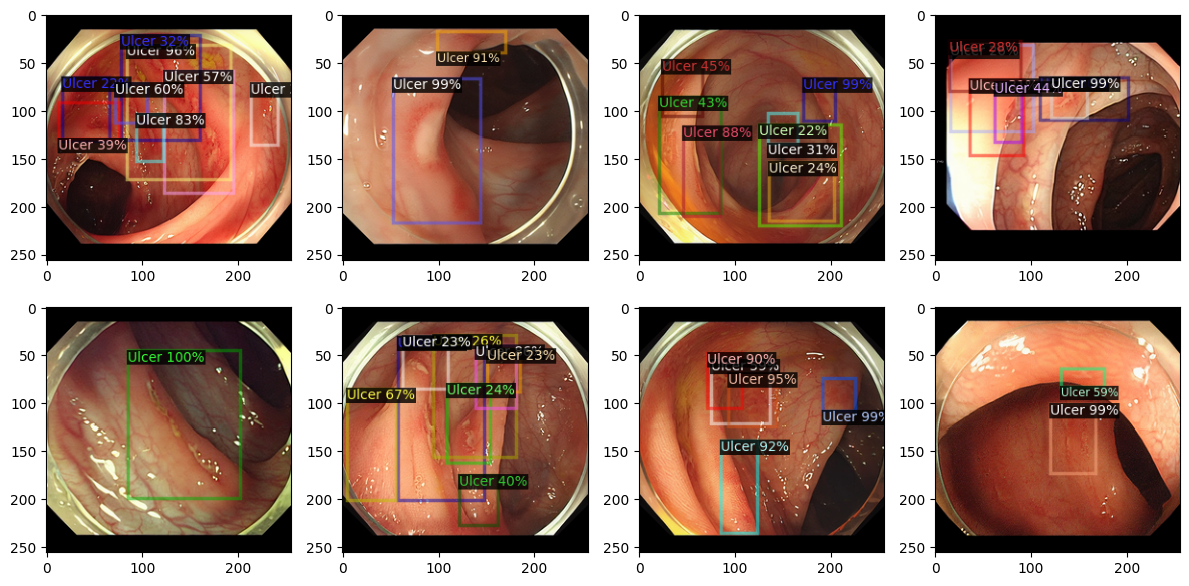

42679

In [21]:
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.2

model = instantiate(cfg.model)
DetectionCheckpointer(model, save_dir=CFG.output_dir).resume_or_load(
            '/kaggle/input/colonoscopy-mvidet/runs/detect/model_final.pth', resume=False
        )
model.to(CFG.device)
model.eval()

image_id = test_df['image_id'].unique()

plt.style.use('default')
plt.figure(figsize=(12,6))

for i in range(8):
    plt.subplot(2,4,i+1)
    path = f'/kaggle/input/colonoscopy-256x256-resized-png/test/{image_id[i]}'
    inputs = cv2.imread(path); inputs = cv2.resize(inputs, (CFG.img_size[0], CFG.img_size[0])) 
    inputs = inputs[:,:,::-1]

    visualizer = Visualizer(inputs, metadata=colonoscopy_metadata, scale=1.0)
    
    image = torch.as_tensor(inputs.astype('float32').transpose(2,0,1))
    image.to(CFG.device)
    inputs = [{'image': image, 'height': CFG.img_size[1], 'width': CFG.img_size[0]}]

    with torch.no_grad(): 
        output = model(inputs)
    
    out = visualizer.draw_instance_predictions(output[0]['instances'].to('cpu'))
    plt.imshow(out.get_image())
    # plt.axis('off')
    

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

## 7. Evaluation
___

### Method1: map-boxes

In [22]:
submission_list = []

for i, row in tqdm(submission_det.iterrows(), total=len(submission_det)):
    image_id = row['image_id']
    string_decoded = string_decoder(row['PredictionString'])

    for  (class_id, score, xmin, ymin, xmax, ymax) in zip(*string_decoded):
        submission_list.append(
            {
                'image_id': image_id,
                'lesion_label': int(class_id),
                'score': float(score),
                'x_min': float(xmin),
                'y_min': float(ymin),
                'x_max': float(xmax),
                'y_max': float(ymax),
                }
        )

submission_metric = pd.DataFrame(submission_list, columns=['image_id', 'lesion_label', 'score','x_min','y_min', 'x_max', 'y_max'])

100%|██████████| 400/400 [00:00<00:00, 2536.51it/s]


In [23]:
ann = test_df.copy()
det = submission_metric.copy()

ann = ann[['image_id','lesion_label','x_min','x_max','y_min','y_max']].values

det = det[['image_id','lesion_label', 'score','x_min','x_max','y_min','y_max']].values

mean_ap_50, average_precisions_50 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.5)
mean_ap_75, average_precisions_75 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.75)


Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.446623 |     180
1                              | 0.718309 |     116
2                              | 0.869921 |     200
mAP: 0.678284
Number of files in annotations: 400
Number of files in predictions: 400
Unique classes: 3
Detections length: 400
Annotations length: 400
0                              | 0.041152 |     180
1                              | 0.429730 |     116
2                              | 0.527499 |     200
mAP: 0.332794


### Method2: Detectron2 Evaluation
___

In [24]:
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.0

evaluator = COCOEvaluator("colonoscopy_test", ("bbox",), False, output_dir=os.path.join(CFG.output_dir, 'inference'))

test_loader = build_detection_test_loader(
      dataset = get_detection_dataset_dicts(names='colonoscopy_test'),
      mapper=DatasetMapper(is_train=False, image_format=CFG.input_format,
                           augmentations = [T.ResizeScale(min_scale=1.0, 
                                                          max_scale=1.0, 
                                                          target_width=CFG.img_size[0],
                                                          target_height=CFG.img_size[1])]),
      batch_size = CFG.ims_per_batch,
      num_workers = CFG.num_workers,
      )

## Build and Load Model
model = instantiate(cfg.model)
DetectionCheckpointer(model, save_dir=CFG.output_dir).resume_or_load(
            '/kaggle/input/colonoscopy-mvidet/runs/detect/model_final.pth', resume=False
        )
model.to(CFG.device)
model.eval()

## Evaluate Metrics
result = inference_on_dataset(model, test_loader, evaluator)

Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.

In [25]:
!ls runs/predict/inference

"""instances_predictions.pth"""
## a file that can be loaded with 'torch.load'
## contains all the results in the format they are produced by the model 
## output format: pascal_voc(xmin, ymin, xmax, ymax)

"""coco_instances_results.json"""
## a json file in CoCo's result format 
## max_dets_per_image: limit on the maximum number of detections per image
## By Default in COCO, this limit is to 100.

"""colonoscopy_test_coco_format.json"""
## a json file in Coco's test dataset format

coco_instances_results.json	   colonoscopy_test_coco_format.json.lock
colonoscopy_test_coco_format.json  instances_predictions.pth


'colonoscopy_test_coco_format.json'